In [1]:
# Cell 1: Install necessary libraries
!pip install torch gymnasium wandb numpy matplotlib


In [2]:
# Cell 2: Imports
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import wandb
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo


In [3]:
# Cell 3: Login to your wandb account (only once per device)
# (Run interactively in the notebook environment)
wandb.login()

# Start a new wandb project (this will create one run; we will reuse this run for logging)
wandb.init(project="RL_Assignment2_DQN_DDQN", name="DQN_vs_DDQN_Experiments", reinit=True)


wandb: Currently logged in as: karim-mahmoud021 (karim-mahmoud021-cairo-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [4]:
# Cell 4: Q-network definition (same as before)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_units=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_units)
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.fc3 = nn.Linear(hidden_units, action_size)

    def forward(self, x):
        # accept either 1D or 2D tensors
        if x.dim() == 1:
            x = x.unsqueeze(0)
            squeeze_out = True
        else:
            squeeze_out = False
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        out = self.fc3(x)
        if squeeze_out:
            return out.squeeze(0)
        return out


In [5]:
# Cell 5: Replay buffer (unchanged)
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


In [6]:
# Cell 6: DQNAgent (modified: save/load, small robustness fixes)
class DQNAgent:
    def __init__(self, state_size, action_size, config):
        self.state_size = state_size
        self.action_size = action_size
        
        # Hyperparameters
        self.gamma = config["gamma"]
        self.epsilon = config["epsilon_start"]
        self.epsilon_min = config["epsilon_min"]
        self.epsilon_decay = config["epsilon_decay"]
        self.lr = config["lr"]

        # Networks
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.update_target()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.lr)
        self.memory = ReplayBuffer(config["memory_size"])
        self.batch_size = config["batch_size"]

    def update_target(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        # state: numpy array
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        with torch.no_grad():
            q_values = self.q_network(torch.FloatTensor(state))
        return int(torch.argmax(q_values).item())

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return None
        
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss.item()

    def save(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        torch.save(self.q_network.state_dict(), path)

    def load(self, path, map_location=None):
        self.q_network.load_state_dict(torch.load(path, map_location=map_location))
        self.update_target()


In [ ]:
# Cell 7: DDQNAgent (inherits from DQNAgent with DDQN replay)
class DDQNAgent(DQNAgent):
    def replay(self):
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states)
        next_states = torch.FloatTensor(next_states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # DDQN update rule
        next_actions = self.q_network(next_states).argmax(1)
        next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        return loss.item()


In [8]:
# Cell 8: Utility to describe environment (prints and returns details)
def describe_env(env):
    obs_space = env.observation_space
    act_space = env.action_space

    details = {}
    details["observation_space"] = str(obs_space)
    details["observation_shape"] = getattr(obs_space, "shape", None)
    details["action_space"] = str(act_space)

    if isinstance(act_space, gym.spaces.Discrete):
        details["action_type"] = "discrete"
        details["action_n"] = act_space.n
        details["action_low"] = None
        details["action_high"] = None
    elif isinstance(act_space, gym.spaces.Box):
        details["action_type"] = "continuous"
        details["action_n"] = None
        details["action_low"] = act_space.low
        details["action_high"] = act_space.high
        details["action_shape"] = act_space.shape
    else:
        details["action_type"] = "other"
    
    # Print nicely
    print("=== Environment description ===")
    for k, v in details.items():
        print(f"{k}: {v}")
    print("===============================")
    return details


In [9]:
# Cell 9: Train function (returns trained agent + rewards). Also logs env details to wandb.
def train_agent(env_name, agent_type="DQN", episodes=300, seed=0, save_model=True):
    # reproducibility seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = gym.make(env_name)
    # describe environment (print + return dict)
    env_details = describe_env(env)

    # Discretize continuous actions (e.g., Pendulum-v1)
    if isinstance(env.action_space, gym.spaces.Box):
        action_size = 5  # chosen discretization resolution (documented)
        actions_list = np.linspace(env.action_space.low[0], env.action_space.high[0], action_size)
    else:
        action_size = env.action_space.n
        actions_list = np.arange(action_size)

    state_size = env.observation_space.shape[0]

    config = {
        "gamma": 0.99,
        "epsilon_start": 1.0,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.995,
        "lr": 1e-3,
        "memory_size": 50000,
        "batch_size": 64
    }

    # update wandb config with environment-specific details (not overwriting global config)
    wandb.config.update({
        "env_name": env_name,
        "env_type": env_details["action_type"],
        "obs_shape": env_details["observation_shape"],
        "action_size_used": int(action_size),
    }, allow_val_change=True)

    agent = DQNAgent(state_size, action_size, config) if agent_type == "DQN" else DDQNAgent(state_size, action_size, config)

    rewards_list = []
    for ep in range(episodes):
        state, _ = env.reset(seed=seed + ep)
        total_reward = 0
        done = False

        while not done:
            action_idx = agent.act(state)
            action = actions_list[action_idx]
            if isinstance(env.action_space, gym.spaces.Box):
                # convert to correct shape for Box action
                action_to_env = np.array([action], dtype=env.action_space.dtype)
            else:
                action_to_env = int(action)

            next_state, reward, terminated, truncated, _ = env.step(action_to_env)
            done = terminated or truncated

            agent.remember(state, action_idx, reward, next_state, done)
            loss = agent.replay()
            state = next_state
            total_reward += reward

        agent.update_target()
        rewards_list.append(total_reward)

        # Log to wandb
        wandb.log({
            f"{agent_type}/{env_name}/reward": total_reward,
            f"{agent_type}/{env_name}/epsilon": agent.epsilon
        })

        # lightweight console feedback
        if (ep + 1) % 10 == 0 or ep == 0 or ep == episodes - 1:
            print(f"{agent_type} | {env_name} | Episode {ep+1}/{episodes} | Reward: {total_reward:.2f} | Epsilon: {agent.epsilon:.3f}")

    # optionally save model
    model_path = None
    if save_model:
        os.makedirs("models", exist_ok=True)
        model_path = f"models/{env_name}_{agent_type}.pth"
        agent.save(model_path)
        print(f"Saved model to: {model_path}")

    env.close()
    return agent, rewards_list, {"env_details": env_details, "actions_list": actions_list, "model_path": model_path}


In [10]:
# Cell 10: Evaluation + video recording function for a trained agent
def evaluate_and_record(agent, env_name, actions_list, agent_type="DQN", episodes=3, seed=42):
    # Create directory for videos
    video_folder = f"videos/{env_name}/{agent_type}"
    os.makedirs(video_folder, exist_ok=True)

    # Create env with render_mode required by RecordVideo
    try:
        base_env = gym.make(env_name, render_mode="rgb_array")
    except TypeError:
        # some env versions don't accept render_mode here; try without and wrap later
        base_env = gym.make(env_name)
    env = RecordVideo(base_env, video_folder=video_folder, episode_trigger=lambda e: True)
    
    # Print environment summary again (and log to wandb summary)
    details = describe_env(base_env)
    wandb.log({f"{agent_type}/{env_name}/env_description": str(details)})

    all_episode_rewards = []
    for ep in range(episodes):
        state, _ = env.reset(seed=seed + ep)
        done = False
        total_reward = 0
        step = 0

        while not done:
            action_idx = agent.act(state)
            # map discrete action idx back to env action
            action = actions_list[action_idx]
            if isinstance(base_env.action_space, gym.spaces.Box):
                action_to_env = np.array([action], dtype=base_env.action_space.dtype)
            else:
                action_to_env = int(action)

            next_state, reward, terminated, truncated, _ = env.step(action_to_env)
            done = terminated or truncated
            state = next_state
            total_reward += reward
            step += 1

        all_episode_rewards.append(total_reward)
        print(f"[VIDEO] {agent_type} | {env_name} | Eval Episode {ep+1}/{episodes} | Reward: {total_reward:.2f} | Steps: {step}")

    env.close()
    # list created video files
    vids = sorted([os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith(".mp4")])
    print(f"Saved {len(vids)} videos to {video_folder}")
    # Log videos to wandb (one by one)
    for i, v in enumerate(vids):
        try:
            wandb.log({f"{agent_type}/{env_name}/video_{i}": wandb.Video(v, fps=30, format="mp4")})
        except Exception as e:
            print("WandB video upload failed:", e)

    return all_episode_rewards, vids


In [ ]:
# Cell 11: Run training for list of environments and both agent types, then evaluate & record videos
envs = ["CartPole-v1", "Acrobot-v1", "MountainCar-v0", "Pendulum-v1"]

# We'll keep results store
results = {}

for env_name in envs:
    print(f"\n{'='*60}\nTRAINING {env_name} with DQN\n{'='*60}")
    dqn_agent, dqn_rewards, dqn_meta = train_agent(env_name, agent_type="DQN", episodes=100, seed=0, save_model=True)
    print(f"\n{'='*60}\nTRAINING {env_name} with DDQN\n{'='*60}")
    ddqn_agent, ddqn_rewards, ddqn_meta = train_agent(env_name, agent_type="DDQN", episodes=100, seed=0, save_model=True)
    
    # Save results metadata
    results[env_name] = {
        "DQN": {"agent": dqn_agent, "rewards": dqn_rewards, "meta": dqn_meta},
        "DDQN": {"agent": ddqn_agent, "rewards": ddqn_rewards, "meta": ddqn_meta}
    }

    # Evaluate and record short videos (3 episodes each)
    print(f"\nRecording evaluation videos for {env_name} with DQN")
    dqn_eval_rewards, dqn_videos = evaluate_and_record(dqn_agent, env_name, dqn_meta["actions_list"], agent_type="DQN", episodes=3)
    print(f"\nRecording evaluation videos for {env_name} with DDQN")
    ddqn_eval_rewards, ddqn_videos = evaluate_and_record(ddqn_agent, env_name, ddqn_meta["actions_list"], agent_type="DDQN", episodes=3)

    # store evaluation info
    results[env_name]["DQN"]["eval_rewards"] = dqn_eval_rewards
    results[env_name]["DQN"]["videos"] = dqn_videos
    results[env_name]["DDQN"]["eval_rewards"] = ddqn_eval_rewards
    results[env_name]["DDQN"]["videos"] = ddqn_videos



TRAINING CartPole-v1 with DQN
=== Environment description ===
observation_space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
observation_shape: (4,)
action_space: Discrete(2)
action_type: discrete
action_n: 2
action_low: None
action_high: None
DQN | CartPole-v1 | Episode 1/150 | Reward: 18.00 | Epsilon: 1.000
DQN | CartPole-v1 | Episode 10/150 | Reward: 12.00 | Epsilon: 0.554
DQN | CartPole-v1 | Episode 20/150 | Reward: 109.00 | Epsilon: 0.075
DQN | CartPole-v1 | Episode 30/150 | Reward: 273.00 | Epsilon: 0.010
DQN | CartPole-v1 | Episode 40/150 | Reward: 500.00 | Epsilon: 0.010
DQN | CartPole-v1 | Episode 50/150 | Reward: 380.00 | Epsilon: 0.010
DQN | CartPole-v1 | Episode 60/150 | Reward: 198.00 | Epsilon: 0.010
DQN | CartPole-v1 | Episode 70/150 | Reward: 195.00 | Epsilon: 0.010
DQN | CartPole-v1 | Episode 80/150 | Reward: 238.00 | Epsilon: 0.010
DQN | CartPole-v1 | Episode 90/150 | Reward: 229.00 | Epsilon: 0

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\CartPole-v1\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DQN | CartPole-v1 | Eval Episode 1/3 | Reward: 256.00 | Steps: 256
[VIDEO] DQN | CartPole-v1 | Eval Episode 2/3 | Reward: 236.00 | Steps: 236
[VIDEO] DQN | CartPole-v1 | Eval Episode 3/3 | Reward: 246.00 | Steps: 246


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/CartPole-v1/DQN


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\CartPole-v1\DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



Recording evaluation videos for CartPole-v1 with DDQN
=== Environment description ===
observation_space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
observation_shape: (4,)
action_space: Discrete(2)
action_type: discrete
action_n: 2
action_low: None
action_high: None
[VIDEO] DDQN | CartPole-v1 | Eval Episode 1/3 | Reward: 176.00 | Steps: 176
[VIDEO] DDQN | CartPole-v1 | Eval Episode 2/3 | Reward: 195.00 | Steps: 195
[VIDEO] DDQN | CartPole-v1 | Eval Episode 3/3 | Reward: 194.00 | Steps: 194


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/CartPole-v1/DDQN

TRAINING Acrobot-v1 with DQN
=== Environment description ===
observation_space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
observation_shape: (6,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
action_low: None
action_high: None
DQN | Acrobot-v1 | Episode 1/150 | Reward: -361.00 | Epsilon: 0.223
DQN | Acrobot-v1 | Episode 10/150 | Reward: -347.00 | Epsilon: 0.010
DQN | Acrobot-v1 | Episode 20/150 | Reward: -320.00 | Epsilon: 0.010
DQN | Acrobot-v1 | Episode 30/150 | Reward: -413.00 | Epsilon: 0.010
DQN | Acrobot-v1 | Episode 40/150 | Reward: -244.00 | Epsilon: 0.010
DQN | Acrobot-v1 | Episode 50/150 | Reward: -173.00 | Epsilon: 0.010
DQN | Acrobot-v1 | Episode 60/150 | Reward: -218.00 | Epsilon: 0.010
DQN | Acrobot-v1 | Episode 70/150 | Reward: -141.00 | Epsilon: 0.010
DQN | Acrobot-v1 | Episode 80/150 | Reward: -252.00 | Ep

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\Acrobot-v1\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DQN | Acrobot-v1 | Eval Episode 1/3 | Reward: -72.00 | Steps: 73
[VIDEO] DQN | Acrobot-v1 | Eval Episode 2/3 | Reward: -84.00 | Steps: 85
[VIDEO] DQN | Acrobot-v1 | Eval Episode 3/3 | Reward: -96.00 | Steps: 97


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Acrobot-v1/DQN

Recording evaluation videos for Acrobot-v1 with DDQN
=== Environment description ===
observation_space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
observation_shape: (6,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
action_low: None
action_high: None


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\Acrobot-v1\DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DDQN | Acrobot-v1 | Eval Episode 1/3 | Reward: -61.00 | Steps: 62
[VIDEO] DDQN | Acrobot-v1 | Eval Episode 2/3 | Reward: -186.00 | Steps: 187
[VIDEO] DDQN | Acrobot-v1 | Eval Episode 3/3 | Reward: -82.00 | Steps: 83


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Acrobot-v1/DDQN

TRAINING MountainCar-v0 with DQN
=== Environment description ===
observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation_shape: (2,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
action_low: None
action_high: None
DQN | MountainCar-v0 | Episode 1/150 | Reward: -200.00 | Epsilon: 0.503
DQN | MountainCar-v0 | Episode 10/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 20/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 30/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 40/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 50/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 60/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 70/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 80/150 | Reward: -200.00 | Epsilon: 0.010
DQN | MountainCar-v0 | Episode 90/150 | Reward: -200

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\MountainCar-v0\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DQN | MountainCar-v0 | Eval Episode 1/3 | Reward: -200.00 | Steps: 200
[VIDEO] DQN | MountainCar-v0 | Eval Episode 2/3 | Reward: -200.00 | Steps: 200
[VIDEO] DQN | MountainCar-v0 | Eval Episode 3/3 | Reward: -200.00 | Steps: 200


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/MountainCar-v0/DQN

Recording evaluation videos for MountainCar-v0 with DDQN
=== Environment description ===
observation_space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
observation_shape: (2,)
action_space: Discrete(3)
action_type: discrete
action_n: 3
action_low: None
action_high: None


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\MountainCar-v0\DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DDQN | MountainCar-v0 | Eval Episode 1/3 | Reward: -200.00 | Steps: 200
[VIDEO] DDQN | MountainCar-v0 | Eval Episode 2/3 | Reward: -200.00 | Steps: 200
[VIDEO] DDQN | MountainCar-v0 | Eval Episode 3/3 | Reward: -200.00 | Steps: 200


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/MountainCar-v0/DDQN

TRAINING Pendulum-v1 with DQN
=== Environment description ===
observation_space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
observation_shape: (3,)
action_space: Box(-2.0, 2.0, (1,), float32)
action_type: continuous
action_n: None
action_low: [-2.]
action_high: [2.]
action_shape: (1,)
DQN | Pendulum-v1 | Episode 1/150 | Reward: -1164.97 | Epsilon: 0.503
DQN | Pendulum-v1 | Episode 10/150 | Reward: -1451.61 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 20/150 | Reward: -3.86 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 30/150 | Reward: -249.50 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 40/150 | Reward: -1.32 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 50/150 | Reward: -125.14 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 60/150 | Reward: -126.01 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 70/150 | Reward: -126.65 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 80/150 | Reward: -274.81 | Epsilon: 0.010
DQN | Pendulum-v1 | Episode 90/150 | R

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\Pendulum-v1\DQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DQN | Pendulum-v1 | Eval Episode 1/3 | Reward: -117.18 | Steps: 200
[VIDEO] DQN | Pendulum-v1 | Eval Episode 2/3 | Reward: -125.37 | Steps: 200
[VIDEO] DQN | Pendulum-v1 | Eval Episode 3/3 | Reward: -226.88 | Steps: 200


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Pendulum-v1/DQN

Recording evaluation videos for Pendulum-v1 with DDQN
=== Environment description ===
observation_space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
observation_shape: (3,)
action_space: Box(-2.0, 2.0, (1,), float32)
action_type: continuous
action_n: None
action_low: [-2.]
action_high: [2.]
action_shape: (1,)


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\wrappers\rendering.py:293: UserWarning: WARN: Overwriting existing videos at e:\RL\RL-Lab2\videos\Pendulum-v1\DDQN folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[VIDEO] DDQN | Pendulum-v1 | Eval Episode 1/3 | Reward: -118.05 | Steps: 200
[VIDEO] DDQN | Pendulum-v1 | Eval Episode 2/3 | Reward: -128.57 | Steps: 200
[VIDEO] DDQN | Pendulum-v1 | Eval Episode 3/3 | Reward: -239.84 | Steps: 200


wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.
wandb: WARNING `fps` argument does not affect the frame rate of the video when providing a file path or raw bytes.


Saved 3 videos to videos/Pendulum-v1/DDQN


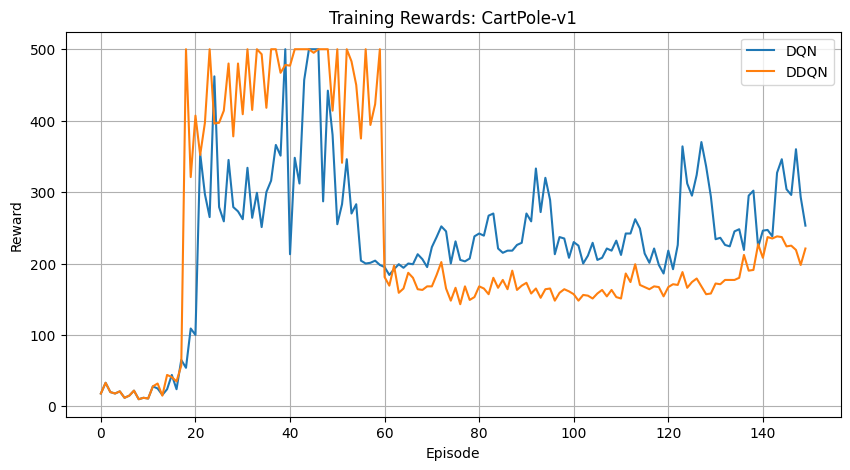

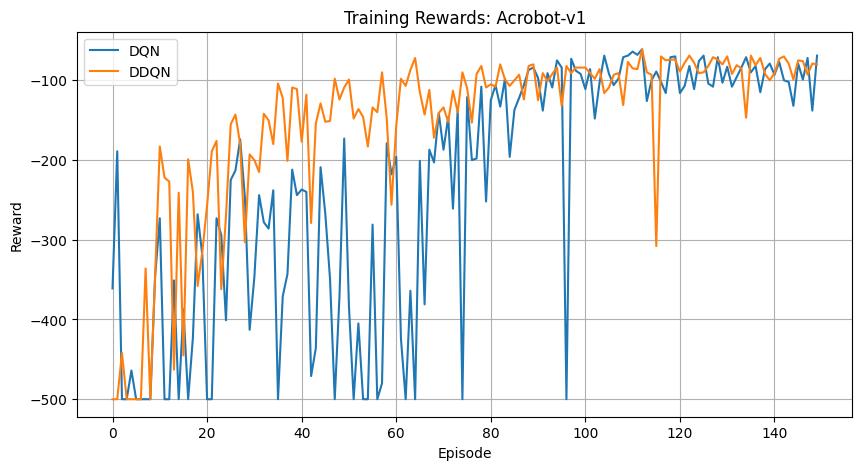

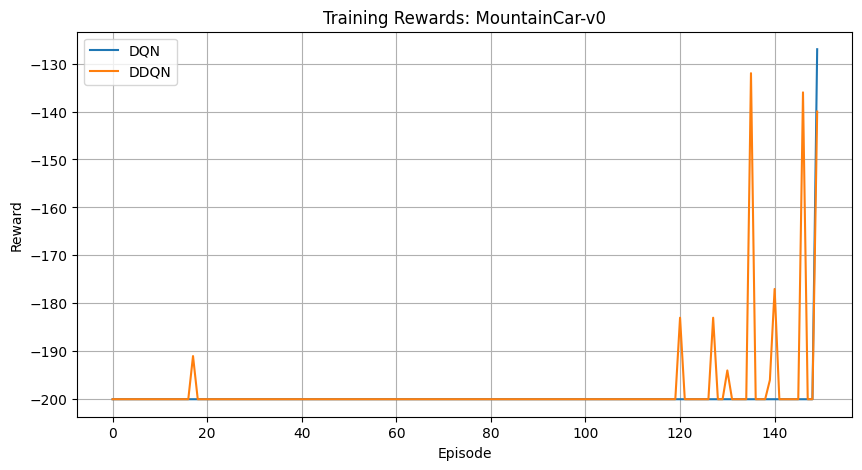

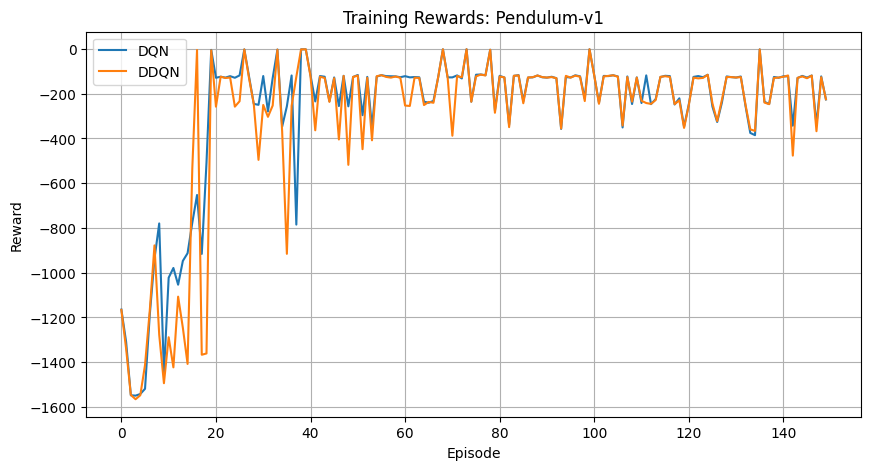

In [12]:
# Cell 12: Quick plotting helper (plot training reward curves for both agents per environment)
def plot_rewards(env_name, results_dict):
    plt.figure(figsize=(10,5))
    plt.title(f"Training Rewards: {env_name}")
    if len(results_dict["DQN"]["rewards"])>0:
        plt.plot(results_dict["DQN"]["rewards"], label="DQN")
    if len(results_dict["DDQN"]["rewards"])>0:
        plt.plot(results_dict["DDQN"]["rewards"], label="DDQN")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: plot for all envs
for env_name in envs:
    plot_rewards(env_name, results[env_name])


In [13]:
# Cell 13: Where to find saved artifacts
print("Models saved in ./models/")
print("Videos saved in ./videos/<ENV_NAME>/<AGENT_TYPE>/")
print("You can download or view videos from the notebook file browser or from wandb run UI (if upload succeeded).")


Models saved in ./models/
Videos saved in ./videos/<ENV_NAME>/<AGENT_TYPE>/
You can download or view videos from the notebook file browser or from wandb run UI (if upload succeeded).


In [14]:
'''
# Notes & details (not a code cell):
- For continuous action envs (Pendulum-v1) we discretize actions into 5 equally spaced actions between env.action_space.low and env.action_space.high. This is recorded in the env metadata and used both for training and evaluation.
- For each environment we print a detailed description (observation space / shape, action space, action type, action bounds). These are also logged to wandb.
- Each trained model is saved under models/{env_name}_{agent_type}.pth.
- Evaluation videos are stored under videos/{env_name}/{agent_type}/ as .mp4 files (RecordVideo wrapper).
- If you want more resolution in discrete approximations for continuous action spaces, increase `action_size` in the train_agent function for that env.
'''


'\n# Notes & details (not a code cell):\n- For continuous action envs (Pendulum-v1) we discretize actions into 5 equally spaced actions between env.action_space.low and env.action_space.high. This is recorded in the env metadata and used both for training and evaluation.\n- For each environment we print a detailed description (observation space / shape, action space, action type, action bounds). These are also logged to wandb.\n- Each trained model is saved under models/{env_name}_{agent_type}.pth.\n- Evaluation videos are stored under videos/{env_name}/{agent_type}/ as .mp4 files (RecordVideo wrapper).\n- If you want more resolution in discrete approximations for continuous action spaces, increase `action_size` in the train_agent function for that env.\n'